# [Introduction to Deep Learning](https://www.datacamp.com/completed/statement-of-accomplishment/course/21654e228f1937d3403f68c9783191c500362728)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/courses/introduction_to_deep_learning/notebook.ipynb)
[![Render nbviewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/datacamp/blob/main/notebooks/courses/introduction_to_deep_learning/notebook.ipynb)

**Contents**
- [Neural Networks](#Neural-Networks)
- [Optimization](#Optimization)
- [Keras](#Keras)
- [Fine-tuning](#Fine-tuning)


In [1]:
%matplotlib inline

import os
import random

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tempfile import TemporaryDirectory
from tensorflow import keras

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# pre-processed titanic training data
titanic = pd.read_csv("titanic.csv")


## Neural Networks

Deep learning is a type of machine learning that relies on artificial _neural networks_: systems of algorithms loosely inspired by biological neural pathways in the brain. The term "deep" simply refers to the fact that these networks are comprised of multiple layers of nodes. Each node serves as a tiny processing unit that takes in a number, performs a mathematical operation on it, and passes the result to each node in the next layer. The output of the final layer is the model's prediction.

Because deep learning models are mathematical in nature, their input can only be numbers. They can't take in raw text and they don't directly output text. They learn how different input numbers lead to different output numbers by algorithmically adjusting the _weights_ and _biases_ of the model as it is exposed to more data. This is known as _representation learning_ and is what allows deep learning models to learn complex non-linear relationships in data and be applied to difficult tasks like computer vision (e.g., Roomba), natural language processing (e.g., ChatGPT), and reinforcement learning (e.g., playing video games, trading stocks, driving cars).

AI researchers study how these networks "learn", how to optimize them, and run experiments with new architectures (and publish their discoveries). Engineers solve problems by choosing the right model (architecture), tuning the hyperparameters specific to that model, training the model on data, and evaluating the model's performance in production.

### Forward Propagation

![Neural network diagram](./nn-1.png)

_Forward propagation_ is the process of computing the output of a neural network given an input. The neural network in the diagram above has 1 input layer with 2 nodes, a _hidden layer_ with 2 nodes, and an output layer with a single node.

The input layer nodes are for each feature (independent variables) and the output layer shape is determined by what you're trying to predict. In this example, we are trying to predict the number of transactions a customer will make in a year given how many bank accounts and children they have. The input layer has 2 nodes: one for accounts and one for children. The output layer has a single node because we are trying to predict a single numerical value.

The nodes are joined by weights, which represent the strength of the connection between nodes. The weights are typically inititally random and the model learns better fitting weights over time. In this example, we are using a "pre-trained" model because we already have the weights.

The hidden layers are where the magic happens. They are "hidden" because they are not directly exposed to the input or output data. While we may know the architecture of the network, as the complexity of the network (layers and nodes) grows keeping track of all the weights and how they are used to compute the output becomes increasingly difficult. This is why neural networks are often referred to as "black boxes". The outputs from these nodes are just numbers that aren't intuitive to us.

**Videos:**
- [@DeepLearningAI: Forward Propagation in a Deep Network](https://www.youtube.com/watch?v=a8i2eJin0lY)
- [@WelchLabsVideo: Forward Propagation](https://www.youtube.com/watch?v=UJwK6jAStmg)

In [2]:
data = np.array([3, 5])  # customer with 3 bank accounts that has 5 children
weights = {
    "node_1": np.array([2, 4]),  # first node in hidden layer
    "node_2": np.array([4, -5]),  # second node in hidden layer
    "output": np.array([2, 7]),  # weights from hidden layer nodes to output layer node
}


In [3]:
# calculate hidden layer dot products (element-wise multiplication and sum)
node_1 = (data * weights["node_1"]).sum()  # (3 * 2) + (5 * 4) = 26
node_2 = (data * weights["node_2"]).sum()  # (3 * 4) + (5 * -5) = -13

# calculate output layer dot product (number of transactions customer will make in a year)
prediction = (np.array([node_1, node_2]) * weights["output"]).sum()
prediction  # (26 * 2) + (-13 * 7) = -39


-39

### Activation Functions

In our example, `-39` is not a good prediction for the number of bank transactions a customer will make. Our neural network so far is linear. We are just taking input numbers and multiplying them by weights. In real-world data, the relationship between input and output is rarely linear. Adding an _activation function_ allows the model to capture non-linearities in the data.

Activation functions are applied to the output of each node in a layer. In early neural networks, the activation function was a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) function like the [logistic](https://en.wikipedia.org/wiki/Logistic_function) or [hyperbolic](https://en.wikipedia.org/wiki/Hyperbolic_functions) tangent (tanh) functions. Modern neural networks use [rectifier](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (e.g., ReLU) or [swish](https://en.wikipedia.org/wiki/Swish_function) (e.g., SwiGLU) functions.

**Videos:**
- [@DeepLearningAI: Activation Functions](https://www.youtube.com/watch?v=Xvg00QnyaIY)
- [@AssemblyAI: Activation Functions in Neural Networks Explained](https://www.youtube.com/watch?v=Fu273ovPBmQ)
- [@SirajRival: Which Activation Function Should I Use?](https://www.youtube.com/watch?v=-7scQpJT7uo)

In [4]:
def relu(x):
    """Rectified linear unit activation function."""
    return max(0, x)


In [5]:
def predict_1(input_data, model_weights):
    node_1 = (input_data * model_weights["node_1"]).sum()
    node_1 = relu(node_1)

    node_2 = (input_data * model_weights["node_2"]).sum()
    node_2 = relu(node_2)

    prediction = (np.array([node_1, node_2]) * model_weights["output"]).sum()
    return prediction


In [6]:
inputs = [
    np.array([3, 5]),
    np.array([1, -1]),
    np.array([0, 0]),
    np.array([8, 4]),
]
outputs = []

for i in inputs:
    outputs.append(predict_1(i, weights))

outputs  # [52, 63, 0, 148]


[52, 63, 0, 148]

### Deeper Networks

![Deeper neural network diagram](./nn-2.png)

So far our network only has 1 hidden layer, but in practice neural nets have many layers with many nodes in each layer. Even more advanced networks could be viewed as a network of networks, where the output of one network could be conditionally fed into another network.

The more complex the network, the more complex the relationships or patterns it can learn. Image recognition networks are a good way to conceptualize this. The outer layers learn simple patterns like edges and corners, and the inner layers learn more complex patterns like shapes and objects the deeper you go.

The goal is to design a network that is able to learn complex patterns while not learning noise or memorizing the entire dataset. This is known as the _bias-variance tradeoff_. A model with high bias is too simple and doesn't learn the patterns in the data. A model with high variance is too complex and learns the noise in the data.

A model's _capacity_ refers to its ability to learn complex patterns. A model with high capacity (more neurons and layers) will be able to learn these patterns, but risks overfitting.

In [7]:
# update model weights
weights = {
    "node_1_1": np.array([2, 4]),
    "node_1_2": np.array([4, -5]),
    "node_2_1": np.array([-1, 2]),
    "node_2_2": np.array([1, 2]),
    "output": np.array([2, 7]),
}


In [8]:
# update `predict` to have 2x2 hidden layers
def predict_2(input_data, model_weights):
    node_1_1 = (input_data * model_weights["node_1_1"]).sum()
    node_1_1 = relu(node_1_1)

    node_1_2 = (input_data * model_weights["node_1_2"]).sum()
    node_1_2 = relu(node_1_2)

    hidden_1 = np.array([node_1_1, node_1_2])

    node_2_1 = (hidden_1 * model_weights["node_2_1"]).sum()
    node_2_1 = relu(node_2_1)

    node_2_2 = (hidden_1 * model_weights["node_2_2"]).sum()
    node_2_2 = relu(node_2_2)

    hidden_2 = np.array([node_2_1, node_2_2])

    prediction = (hidden_2 * model_weights["output"]).sum()
    return prediction


In [9]:
prediction = predict_2(data, weights)
prediction  # 182


182

## Optimization

### Loss Functions

_Loss functions_ are mathematical functions that measure the difference between the predicted outputs of the network and the actual target values (labels) during training. The goal of training is to adjust the weights in such a way that the loss is minimized (close to zero) for every example in the training dataset.

The loss function used depends on the type of problem being solved. For regression problems, the loss function is typically mean squared error (MSE). Other regression loss functions include mean absolute error (MAE) and Huber loss (combination of MSE and MAE less sensitive to outliers).

For classification problems, a cross-entropy loss function is typically used. Binary cross-entropy for binary classification, categorical cross-entropy for multi-class (labels are one-hot encoded), and sparse categorical cross-entropy (labels are integers).

**Videos:**
- [@StatQuest: Cross Entropy](https://www.youtube.com/watch?v=6ArSys5qHAU)

In [10]:
data = np.array([0, 3])
weights_1 = {
    "node_1": [2, 1],
    "node_2": [1, 2],
    "output": [1, 1],
}
weights_2 = {
    "node_1": [2, 1],
    "node_2": [1, 2],
    "output": [1, 0],
}
target = 3

prediction_1 = predict_1(data, weights_1)
prediction_2 = predict_1(data, weights_2)

error_1 = prediction_1 - target
error_2 = prediction_2 - target
print(error_1)
print(error_2)  # error is 0 (perfect fit)


6
0


In [11]:
data = [
    np.array([0, 3]),
    np.array([1, 2]),
    np.array([-1, -2]),
    np.array([4, 0]),
]
weights_1 = {
    "node_1": np.array([2, 1]),
    "node_2": np.array([1, 2]),
    "output": np.array([1, 1]),
}
weights_2 = {
    "node_1": np.array([2, 1]),
    "node_2": np.array([1, 1.5]),
    "output": np.array([1, 1.5]),
}
targets = [1, 3, 5, 7]

predictions_1 = []
predictions_2 = []

for d in data:
    predictions_1.append(predict_1(d, weights_1))
    predictions_2.append(predict_1(d, weights_2))

mse_1 = mean_squared_error(targets, predictions_1)
mse_2 = mean_squared_error(targets, predictions_2)
print(f"MSE with weights_1: {mse_1:.2f}")  # 37.50
print(f"MSE with weights_2: {mse_2:.2f}")  # 49.89


MSE with weights_1: 37.50
MSE with weights_2: 49.89


### Backpropagation and Gradient Descent

Once the dataset has been fed through the network and predictions have been output, the loss function is used to calculate the residual error for each example. During backpropagation, the error is propagated backwards through the network. The calculus chain rule is used to calculate the derivative of the loss function with respect to each weight. In other words, it's quantifying how much each weight contributed to the error.

For each weight, the derivative of the loss function is multiplied by the derivative of the activation function. This is known as the _gradient_. It is the direction (sign) and magnitude (absolute value) of the steepest increase (slope) of the loss function. In order to minimize the loss function, you want to move in the opposite direction of the gradient. This is known as _gradient descent_.

**Backpropagation videos:**
- [@3Blue1Brown: What is backpropagation really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
- [@3Blue1Brown: Backpropagation calculus](https://www.youtube.com/watch?v=tIeHLnjs5U8)
- [@StatQuest: Backpropagation Main Ideas](https://www.youtube.com/watch?v=IN2XmBhILt4)
- [@AssemblyAI: Backpropagation Explained](https://www.youtube.com/watch?v=LHLrXavT1gQ)

**Gradient descent videos:**
- [@3Blue1Brown: Gradient descent, how neural networks learn](https://www.youtube.com/watch?v=IHZwWFHWa-w)
- [@StatQuest: Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8)
- [@StatQuest: Stochastic Gradient Descent, Clearly Explained](https://www.youtube.com/watch?v=vMh0zPT0tLI)
- [@WelchLabsVideo: Gradient Descent](https://www.youtube.com/watch?v=5u0jaA3qAGk)


In [12]:
data = np.array([1, 2, 3])
weights = np.array([0, 2, 1])
target = 0
learning_rate = 0.01

predictions = (data * weights).sum()
error = predictions - target
slope = 2 * data * error

weights_updated = weights - learning_rate * slope
predictions_updated = (data * weights_updated).sum()
error_updated = predictions_updated - target

print(error)  # 7
print(error_updated)  # 5.04


7
5.04


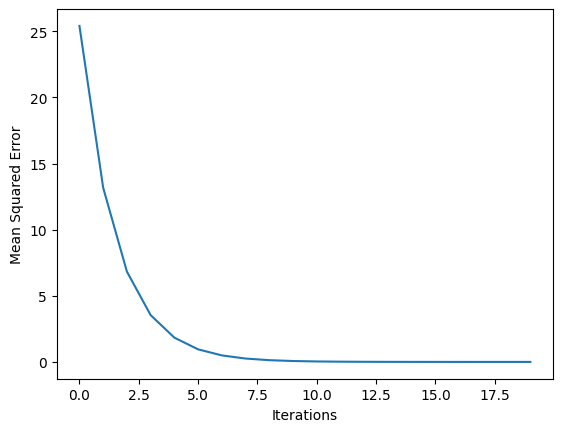

In [13]:
def get_error(input_data, target, weights):
    """Calculate the MSE given input data, target, and weights."""
    predictions = (input_data * weights).sum()
    error = predictions - target
    return error


def get_slope(input_data, target, weights):
    """Calculate the slope given input data, target, and weights."""
    error = get_error(input_data, target, weights)
    slope = 2 * input_data * error
    return slope


def get_mse(input_data, target, weights):
    """Calculate the MSE given input data, target, and weights."""
    errors = get_error(input_data, target, weights)
    mse = np.mean(errors**2)
    return mse


n_updates = 20
mse_hist = []
learning_rate = 0.01

for i in range(n_updates):
    slope = get_slope(data, target, weights)
    weights = weights - learning_rate * slope
    mse = get_mse(data, target, weights)
    mse_hist.append(mse)

# plot loss over time
plt.plot(mse_hist)
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.show()


## Keras

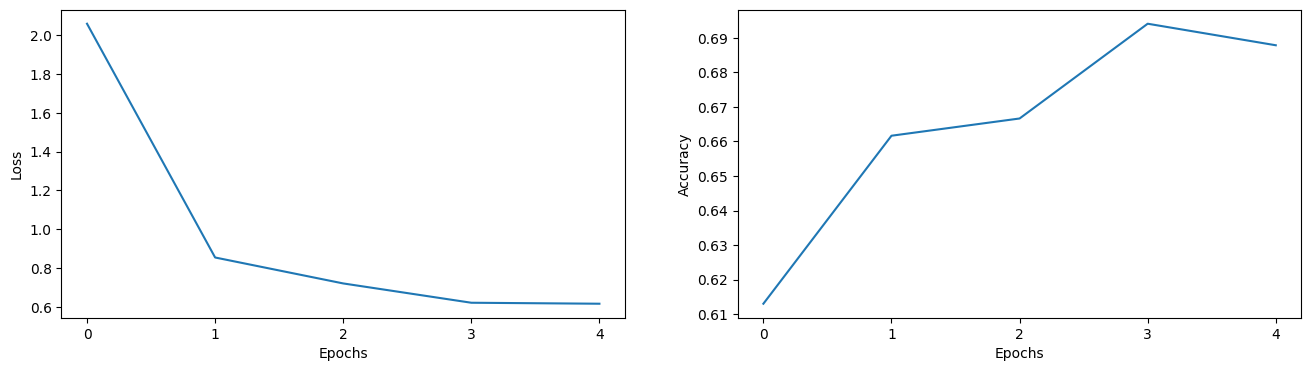

In [14]:
# convert target to categorical (one-hot)
survived = keras.utils.to_categorical(titanic["survived"])

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    titanic.drop("survived", axis=1),
    survived,
    test_size=0.1,
    random_state=42,
)

# add layers and compile
model = keras.Sequential(
    [
        keras.layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="sgd",  # stochastic gradient descent
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# fit model
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    verbose=0,
)

# plot loss and accuracy side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(history.history["loss"])
ax1.set_xlabel("Epochs")
ax1.set_xticks(np.arange(0, len(history.history["loss"])))
ax1.set_ylabel("Loss")
ax2.plot(history.history["accuracy"])
ax2.set_xlabel("Epochs")
ax2.set_xticks(np.arange(0, len(history.history["accuracy"])))
ax2.set_ylabel("Accuracy")
plt.show()


## Fine-tuning

### Vanishing Gradients

Activation functions like sigmoid and tanh can lead to small gradients. In shallower networks, this isn't necessary an issue; however, in deep networks, the gradients can keep getting smaller and smaller which decays the learning rate. ReLU remedies this by having a derivative of 1 for positive values, which helps prevent the gradient from vanishing.

### Dying Neurons

The derivative of ReLU is:

$f'(x) = \begin{cases}
  1 & \text{if } x > 0 \\
  0 & \text{if } x \leq 0
\end{cases}$

where $f'$ (f-prime) is the derivative of $f$.

The gradient for each weight is calculated by multiplying the derivative of the activation function by the derivative of the loss function. If the activation function is ReLU, then the derivative will be 0 for negative values. Since the gradient is used to calculate how much to update the weight, if it is 0 then the weight will not be updated. This can lead to a condition where the neuron always outputs 0, effectively shutting it off.

Newer activation functions like Leaky ReLU and Swish help prevent this by having a non-zero derivative for negative values.

In [15]:
# grid search for hyperparameters using keras_tuner
def hypermodel(hp):
    units = hp.Int("units", min_value=32, max_value=96, step=32)
    learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3])

    model = keras.Sequential(
        [
            # Swish
            keras.layers.Dense(
                units,
                activation="swish",
                input_shape=(X_train.shape[1],),
            ),
            keras.layers.Dense(units, activation="swish"),
            keras.layers.Dense(y_train.shape[1], activation="softmax"),
        ]
    )
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# use a temporary directory to store results
with TemporaryDirectory() as directory:
    tuner = kt.GridSearch(
        hypermodel,
        objective="accuracy",
        directory=directory,
        seed=42,
    )

    tuner.search(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        verbose=0,
    )

    tuner.results_summary(num_trials=3)


Results summary
Results in /var/folders/_0/vzr7w6510yg9930l0ydhc1mm0000gn/T/tmpvf5gl6t2/untitled_project
Showing 3 best trials
Objective(name="accuracy", direction="max")

Trial 0007 summary
Hyperparameters:
units: 96
learning_rate: 0.01
Score: 0.8014981150627136

Trial 0004 summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.7927590608596802

Trial 0003 summary
Hyperparameters:
units: 64
learning_rate: 0.1
Score: 0.7915105819702148
